## Getting BTC data
- use yfinance to get BTC data
- the project must be as modular as possible, so we want to read variables such as the coin, period, or ticks interval from the configuration file
- this data will serve to implement different strategies, indicators, visualizing profits and losses, and training a RL agent

In [6]:
# imports
%pip install matplotlib mplcursors
%pip install ipympl
%pip install yfinance

import json
import yfinance as yf
import matplotlib.pyplot as plt
import mplcursors
import math
import numpy as np
from typing import Dict
from pandas.core.indexes.datetimes import DatetimeIndex
from pandas.core.frame import DataFrame


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Specify the path to your JSON file
json_file_path = "config.json"

# Open and read the JSON file
with open(json_file_path, "r") as json_file:
    config = json.load(json_file)

# Extract the "map" value
coin = config["coin"]
interval = config["interval"]

In [8]:
Ticker = yf.Ticker(coin)
coin_data = Ticker.history(period="max", interval=interval)

coin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


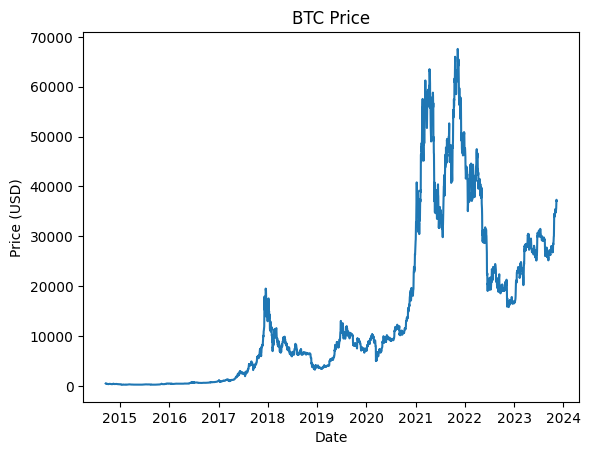

In [12]:
def plot_coin_data(coin: str, coin_data: DataFrame):
    """
    Method plots an interactive graph of the coin data.
    TODO: When hovering over the graph, the date and price of the coin is displayed.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Plot the Close price
    data = ax.plot(coin_data['Close'])
    # Set the title and labels
    ax.set_title(f'{coin} Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    
    # Show the graph
    plt.show()

plot_coin_data("BTC", coin_data)

In [34]:
class Buys(DataFrame):
    """
    Class represents the buys of a coin.
    Index is date of purchase.
    """

    USD_AMOUNT_INVESTED = 'USD Amount Invested'
    COIN_AMOUNT_PURCHASED = 'Coin Amount Purchased'
    COLUMNS = [USD_AMOUNT_INVESTED, COIN_AMOUNT_PURCHASED]

    def __init__(self, index, data):
        if list(data.keys()) != self.COLUMNS:
            raise Exception(f'Invalid columns. Expected {self.COLUMNS} but received {data.keys()}')
            
        super().__init__(data, index=index, columns=self.COLUMNS)

buys_data = {
    Buys.USD_AMOUNT_INVESTED: [100, 100, 100],
    Buys.COIN_AMOUNT_PURCHASED: [1, 0.9, 0.8]
}
buys_index = DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03'])

buys = Buys(buys_index, buys_data)
buys

,USD Amount Invested,Coin Amount Purchased
2023-01-01,100,1.0
2023-01-02,100,0.9
2023-01-03,100,0.8


In [35]:
# implement DCA strategy
def dca_strategy(coin_data: DataFrame, interval: int, investment_amount_usd: int) -> Buys:
    """
    This function implements the DCA strategy.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.

    :param interval: int
        Interval between buying periods.
        For example, if interval = 7, then buy every 7 days.

    :param investment_amount_usd: int
        Amount to invest in USD.

    :return: Buys
        A dictionary of the dates and the number of coins to buy on each date.
    """
    # calculate the number of coins to buy at each date
    buys_date = []
    buys_usd_amount = []
    buys_coin_amount = []
    for i in range(0, len(coin_data), interval):
        buys_date.append(coin_data.index[i])
        buys_usd_amount.append(investment_amount_usd)
        buys_coin_amount.append(investment_amount_usd / coin_data['Close'][i])

    buys_index = DatetimeIndex(buys_date)
    buys_data = {
        Buys.USD_AMOUNT_INVESTED: buys_usd_amount,
        Buys.COIN_AMOUNT_PURCHASED: buys_coin_amount
    }
    return Buys(buys_index, buys_data)

dca_buys = dca_strategy(coin_data, 7, 100)
dca_buys.head()

/tmp/ipykernel_213324/3139822923.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buys_coin_amount.append(investment_amount_usd / coin_data['Close'][i])


,USD Amount Invested,Coin Amount Purchased
2014-09-17 00:00:00+00:00,100,0.218659
2014-09-24 00:00:00+00:00,100,0.236292
2014-10-01 00:00:00+00:00,100,0.260678
2014-10-08 00:00:00+00:00,100,0.283334
2014-10-15 00:00:00+00:00,100,0.253310


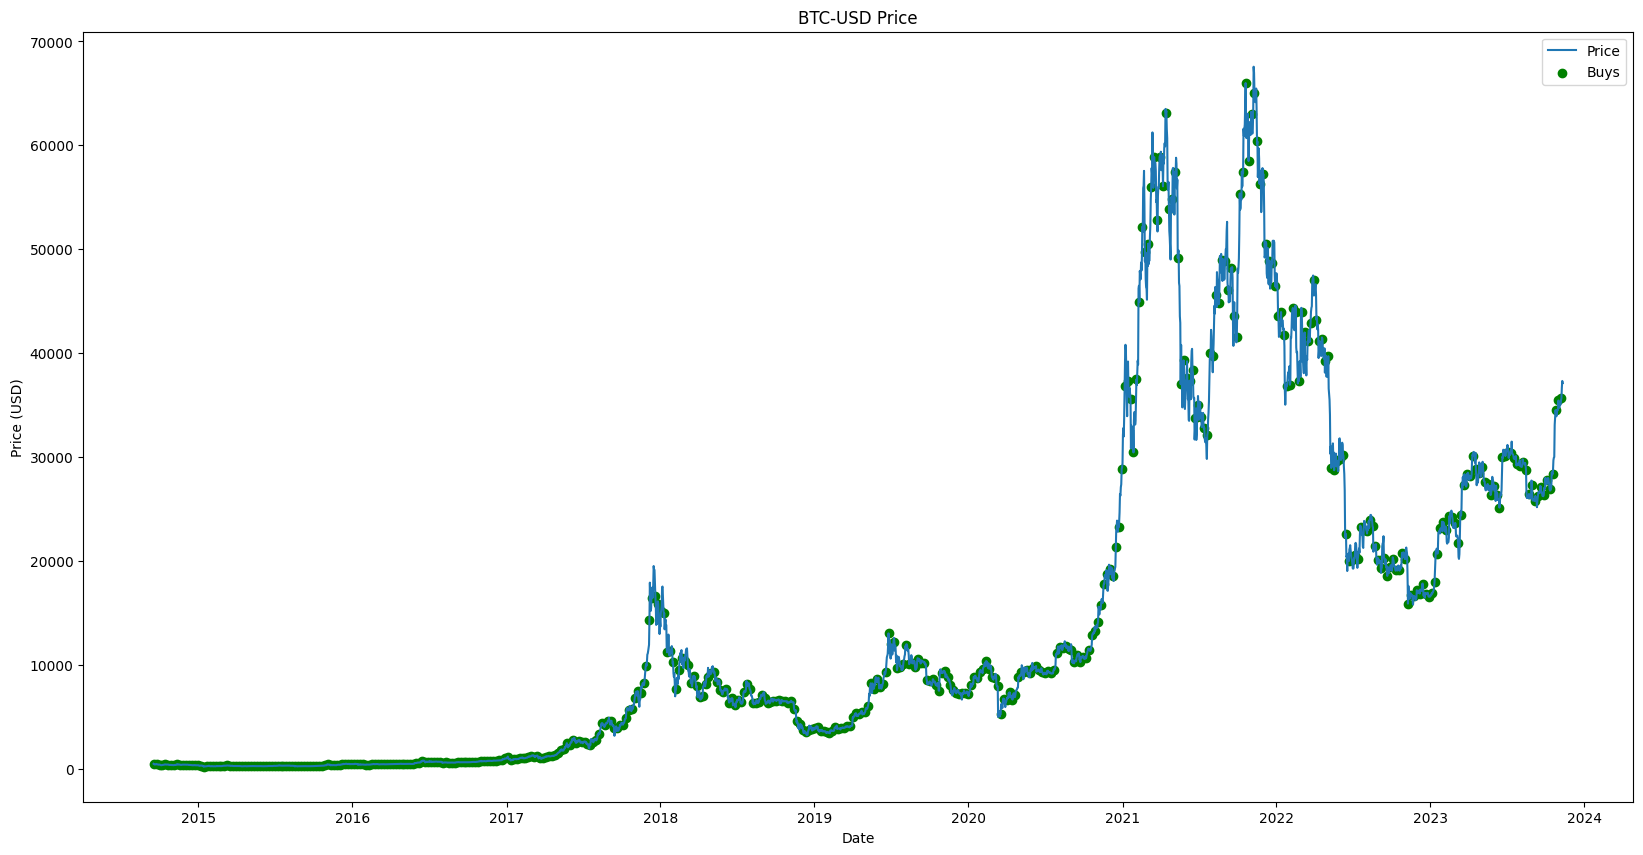

In [36]:
# visualize buys
def plot_buys(coin_data: DataFrame, buys: Buys):
    """
    This function plots the buys dates.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.

    :param buys: Buys
        A dictionary of the dates and the number of coins to buy on each date.
    """
    plt.figure(figsize=(20,10))
    plt.plot(coin_data['Close'], label='Price')
    plt.scatter(buys.index, coin_data.loc[buys.index]['Close'], label='Buys', color='green')
    plt.title(f'{coin} Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
    
plot_buys(coin_data, dca_buys)

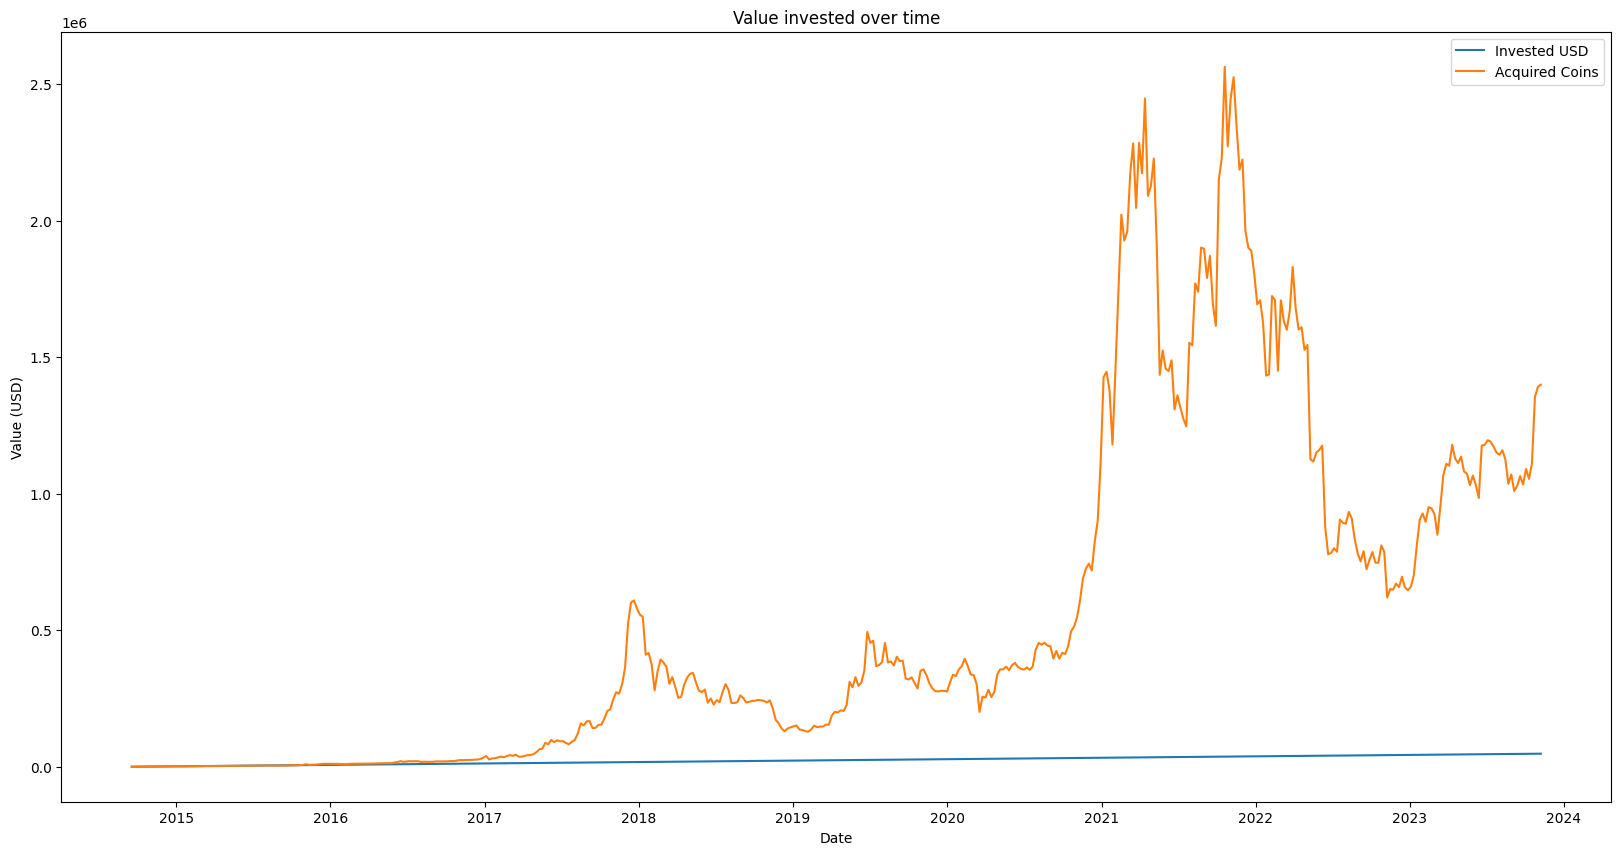

In [39]:
# visualize profit
def plot_profits(coin_data: DataFrame, buys: Buys):
    """
    This function plots the value of invested USD and the value of acquired coins over time.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.

    :param buys: Buys
    """
    plt.figure(figsize=(20,10))
    plt.title('Value invested over time')
    plt.xlabel('Date')
    plt.ylabel('Value (USD)')

    # plot the value of invested USD
    plt.plot(buys.index, buys[Buys.USD_AMOUNT_INVESTED].cumsum(), label='Invested USD')

    # plot the value of acquired coins
    plt.plot(buys.index, buys[Buys.COIN_AMOUNT_PURCHASED].cumsum() * coin_data.loc[buys.index]['Close'], label='Acquired Coins')

    plt.legend()
    plt.show()

plot_profits(coin_data, dca_buys)

/tmp/ipykernel_213324/3139822923.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buys_coin_amount.append(investment_amount_usd / coin_data['Close'][i])


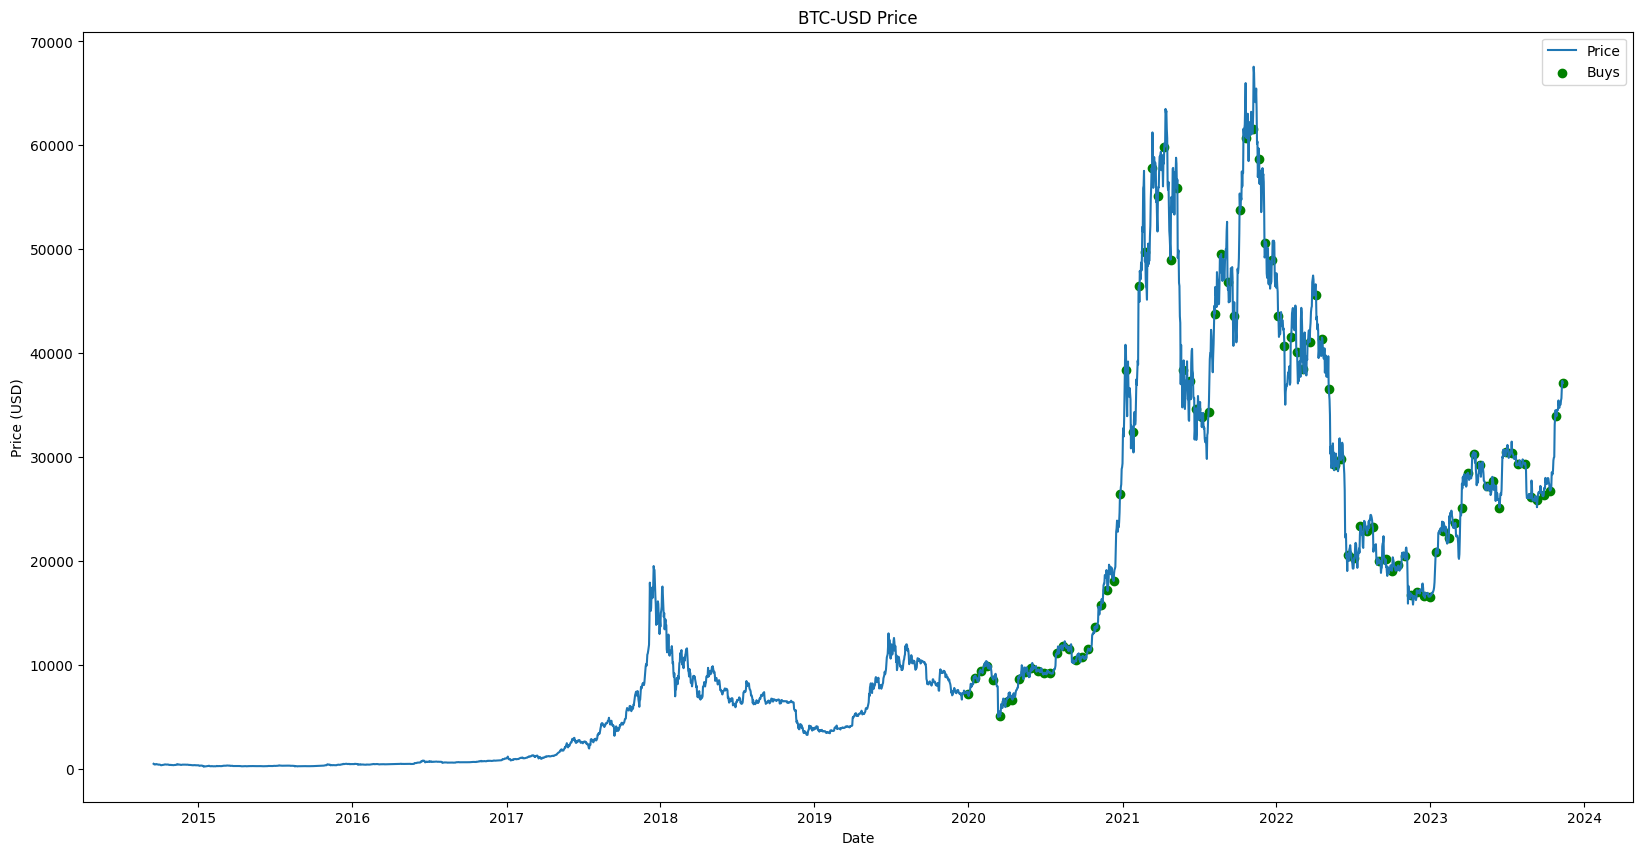

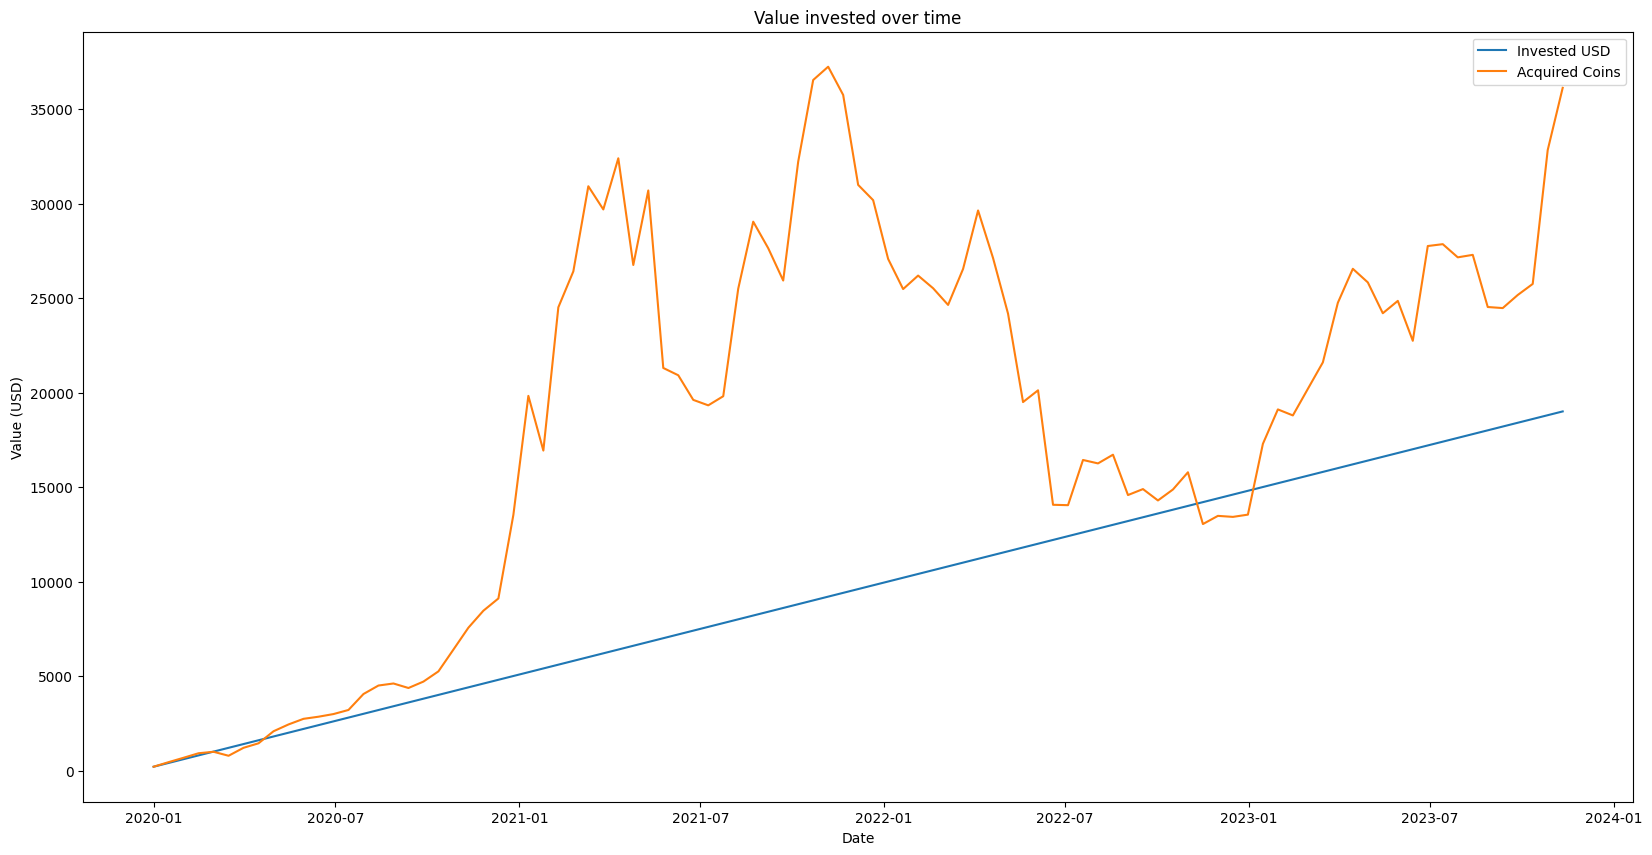

In [63]:
# plot profits of DCA strategy if started at different dates
coin_data_with_start = coin_data.loc['2020-01-01':]
dca_buys_with_start = dca_strategy(coin_data_with_start, 15, 200)

plot_buys(coin_data, dca_buys_with_start)
plot_profits(coin_data, dca_buys_with_start)

### Implement indicators and buying strategies based on them
Indicators to consider:
- simple moving average (SMA)
- exponential moving average (EMA)
- relative strength index (RSI)
- moving average convergence divergence (MACD)
- Bollinger bands BB
- Ichimoku cloud

Strategies:
1. Moving average crossover strategy
Indicators: SMA and EMA
Strategy: Buy when the short-term EMA crosses above the longer-term SMA, indicating a potential uptrend. Sell when the EMA crosses below the SMA, signaling a potential downtrend
Risk management: Implement stop-loss and take-profit levels to manage risk. Avoid trading during periods of reduced volatility

2. RSI overbought/oversold strategy
Indicators: RSI
Strategy: Buy when RSI crosses below 30, indicating oversold conditions, and sell when RSI crosses above 70. This strategy looks for trend reversals at extreme RSI levels

3. MACD crossover strategy
Indicators: MACD
Strategy: Buy when the MACD line crosses above the signal line and sell when it crosses below. Strategy aims to capture momentum shifts in the market.
Risk management: Be cautious of false signals during sideways markets.

4. BB reversion to mean
Indicators: BB
Strategy: Buy when the price touches or falls below the lower BB and then rises back inside the bands, indicating potential support. Sell when the price touches or exceeds the upper BB and then drops back inside, suggesting potential resistance.

5. Ichimoku cloud breakout strategy
Indicators: Ichimoku Cloud
Strategy: Buy when the price crosses above the cloud, and the cloud is green (indicating an uptrend). Sell when the price crosses below the cloud, and the cloud is red.
Risk management: Use the cloud as a dynamic stop-loss level. Adjust stop-loss levels as the cloud moves with the trend ???

6. Dual moving average crossover with RSA confirmation
Indicators: SMA, RSI
Strategy: Buy when the shorter-term SMA crosses above the longer-term SMA and the RSI is above a certain threshold (ie: 50). Sell when the shorter-term SMA crosses below the longer-term SMA or when the RSI falls bellow the threshold.


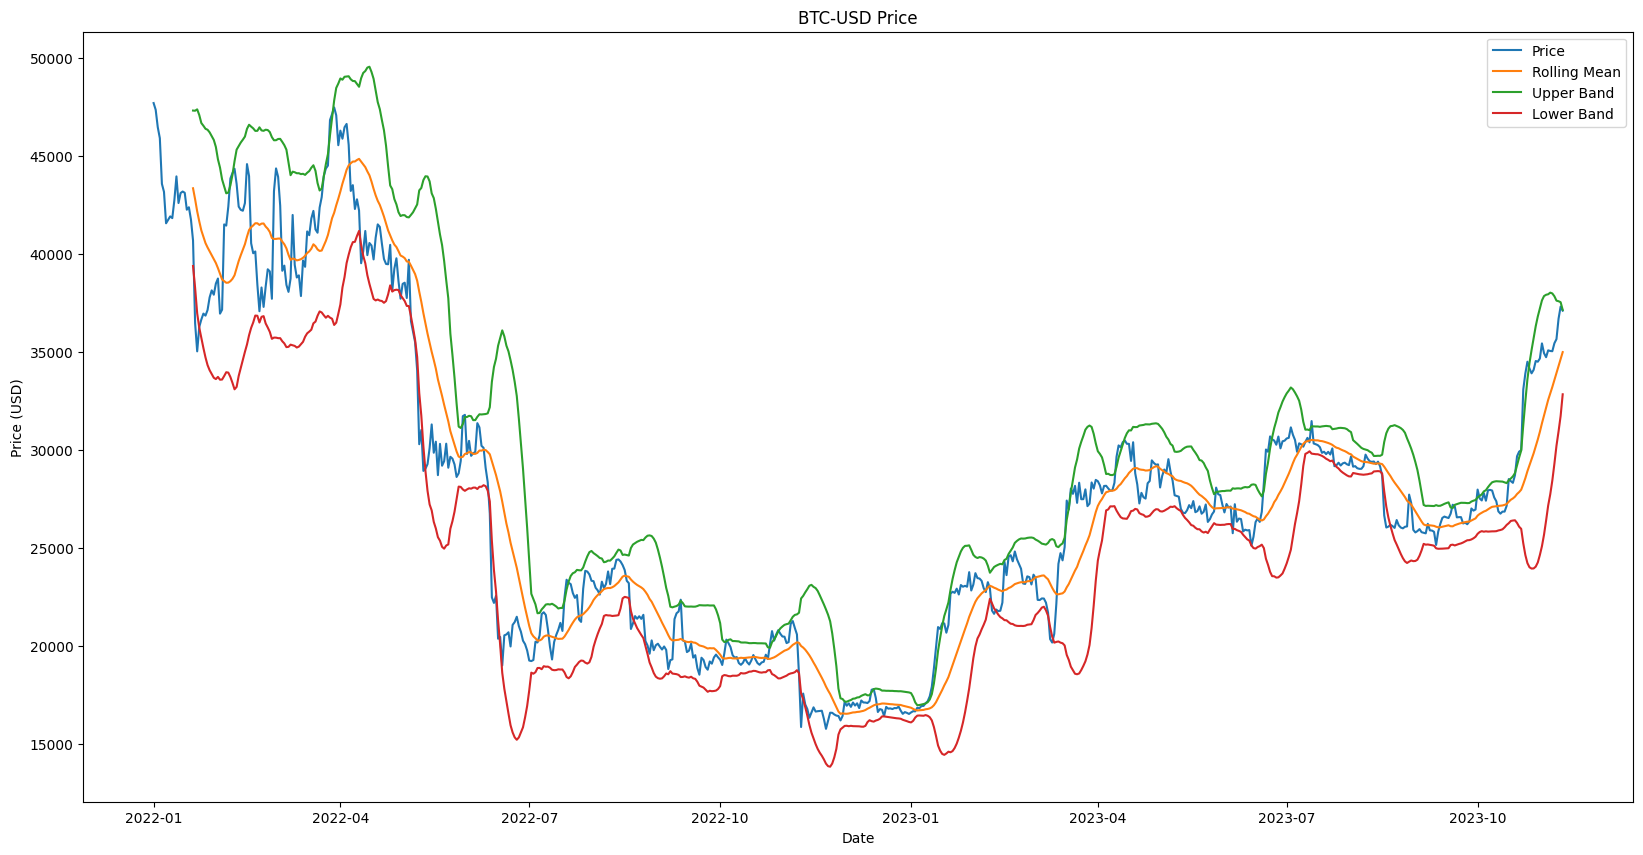

In [71]:
def bollinger_bands(coin_data: DataFrame, window=20) -> DataFrame:
    """
    This function calculates the Bollinger Bands for a coin.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.

    :return: DataFrame
        A DataFrame containing the Bollinger Bands.
    """
    # calculate the rolling mean and standard deviation
    rolling_mean = coin_data['Close'].rolling(window=window).mean()
    rolling_std = coin_data['Close'].rolling(window=window).std()

    # calculate the upper and lower bands
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    # create a DataFrame containing all the bands
    bands = DataFrame({
        'Close': coin_data['Close'],
        'Rolling Mean': rolling_mean,
        'Upper Band': upper_band,
        'Lower Band': lower_band
    })

    return bands

# plot bollinger bands
coin_data_with_start = coin_data.loc['2022-01-01':]
bands = bollinger_bands(coin_data_with_start)

plt.figure(figsize=(20,10))
plt.plot(coin_data_with_start['Close'], label='Price')
plt.plot(bands['Rolling Mean'], label='Rolling Mean')
plt.plot(bands['Upper Band'], label='Upper Band')
plt.plot(bands['Lower Band'], label='Lower Band')
plt.title(f'{coin} Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [73]:
class Action():
    BUY = 'BUY'
    SELL = 'SELL'
    HOLD = 'HOLD'

Action.BUY

'BUY'

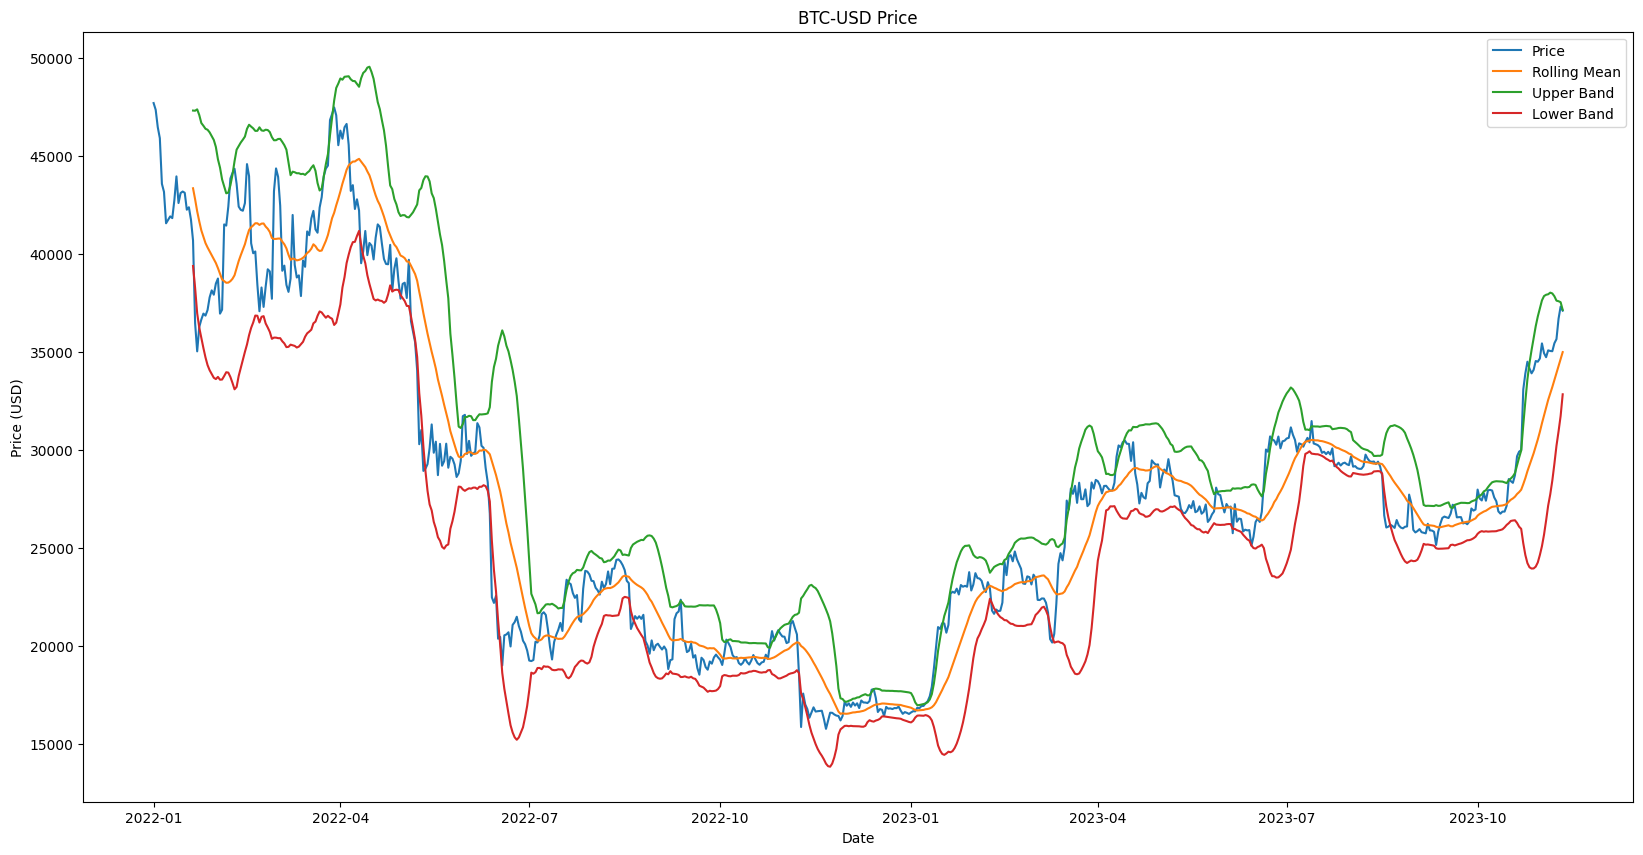

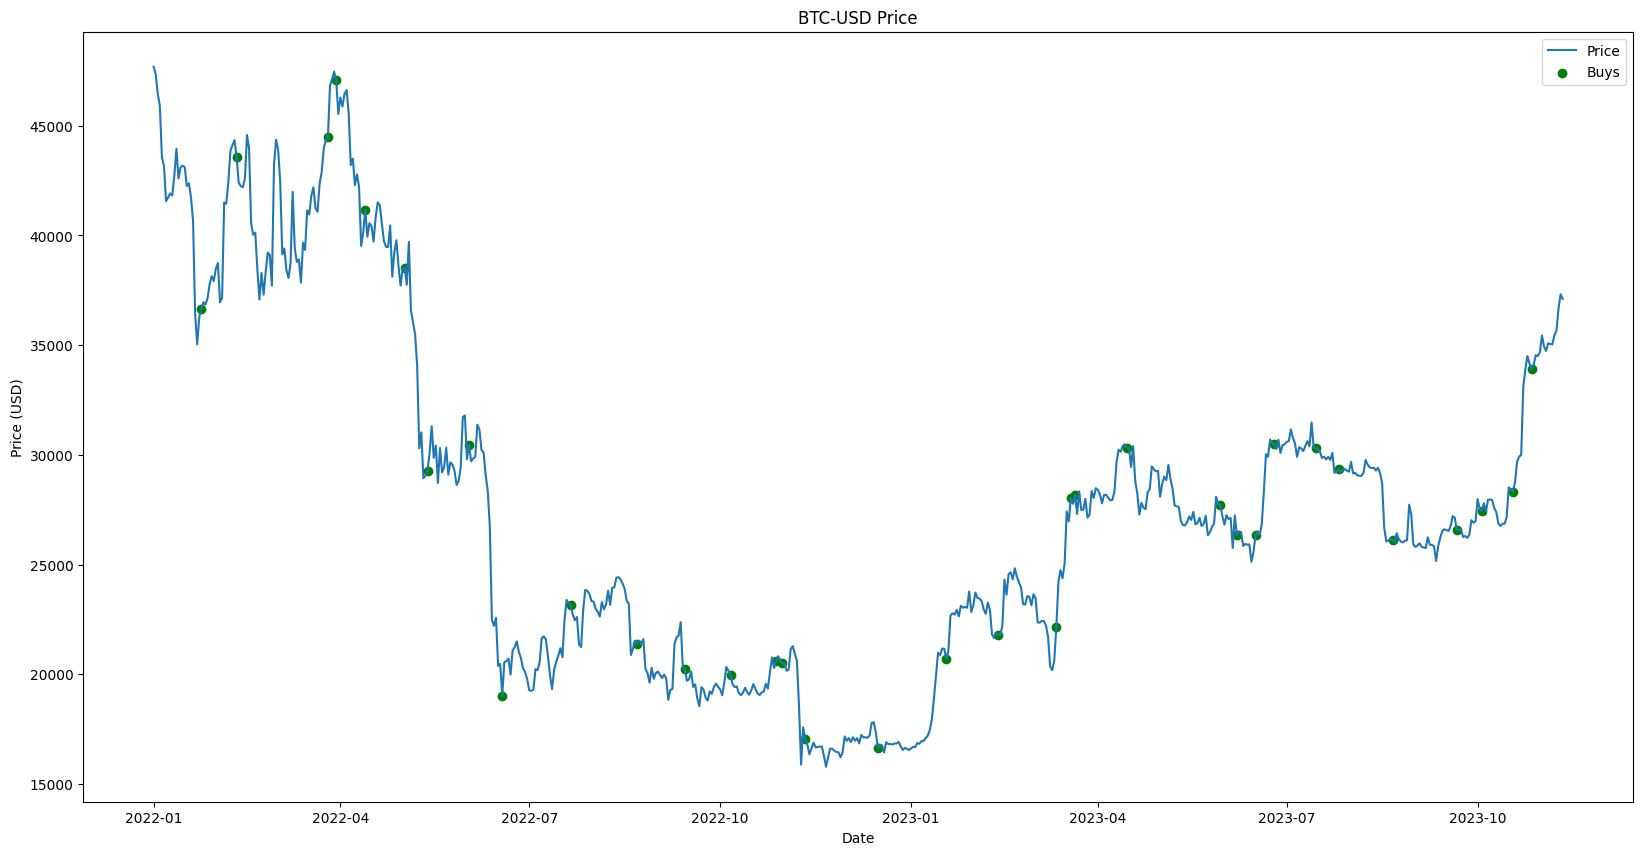

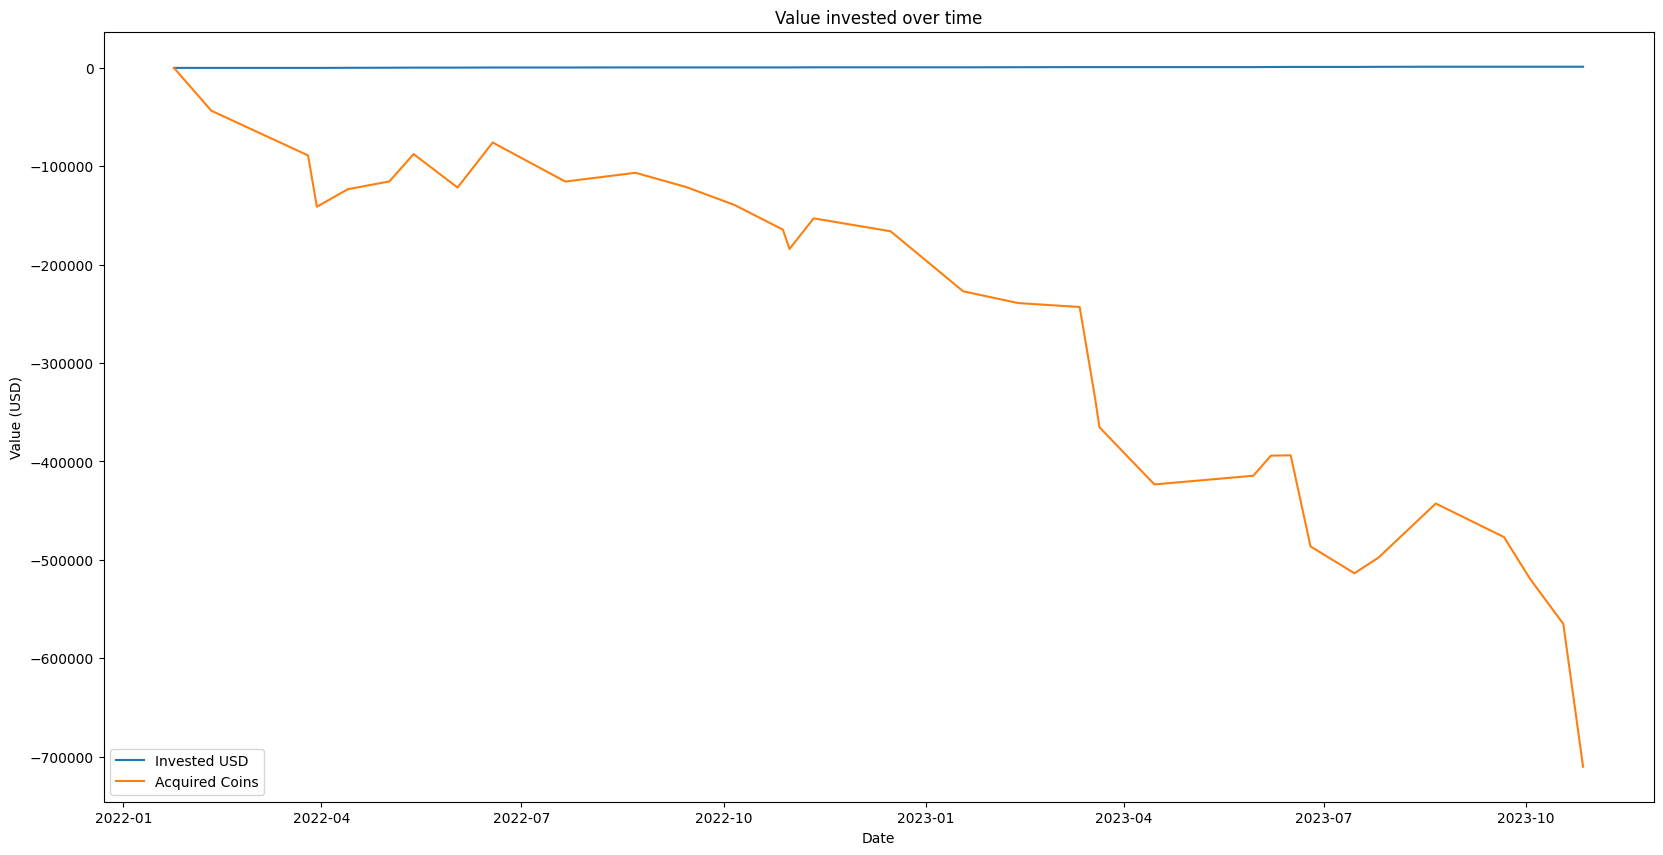

In [79]:
def bollinger_bands_strategy_simple(coin_data: DataFrame, bands: DataFrame) -> Action:
    """
    Function implements instanteous Bollinger Bands strategy.
    Buy when the price touches or falls below the lower BB and then rises back inside the bands.
    Sell when the price touches or exceeds the upper BB and then falls back inside the bands.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.
    
    :param bands: DataFrame
        A DataFrame containing the Bollinger Bands.
    
    :return: Action
        The action to take.
    """
    # if the price exceeded the upper band, and then drops back inside the bands, sell
    # if the price falls below the lower band, and then rises back inside the bands, buy
    # if price is inside the bands
    if bands.iloc[-1]['Lower Band'] < coin_data.iloc[-1]['Close'] < bands.iloc[-1]['Upper Band']:
        # and it previously was above the upper band
        if coin_data.iloc[-2]['Close'] > bands.iloc[-2]['Upper Band']:
            # then sell
            return Action.SELL
        # if it previously was below the lower band
        if coin_data.iloc[-2]['Close'] < bands.iloc[-2]['Lower Band']:
            # then buy
            return Action.BUY
    return Action.HOLD

def bollinger_bands_strategy(coin_data: DataFrame, investment_amount_usd: int, window=20) -> Buys:
    """
    Function implements Bollinger Bands strategy.
    Buy when the price touches or falls below the lower BB and then rises back inside the bands.
    Sell when the price touches or exceeds the upper BB and then falls back inside the bands.

    :param coin_data: DataFrame
        Coin's data in a DataFrame.

    :param investment_amount_usd: int
        Amount to invest in USD.

    :param window: int
        Window size for calculating the Bollinger Bands.

    :return: Buys
        A dictionary of the dates and the number of coins to buy on each date.
    """
    # calculate the Bollinger Bands
    bands = bollinger_bands(coin_data, window=window)

    # calculate the buys
    buys_date = []
    buys_usd_amount = []
    buys_coin_amount = []
    for i in range(1, len(coin_data)):
        if i < window:
            continue

        action = bollinger_bands_strategy_simple(coin_data.iloc[:i], bands.iloc[:i])
        if action == Action.BUY:
            buys_date.append(coin_data.index[i])
            buys_usd_amount.append(investment_amount_usd)
            buys_coin_amount.append(investment_amount_usd / coin_data.iloc[i]['Close'])
        elif action == Action.SELL:
            buys_date.append(coin_data.index[i])
            buys_usd_amount.append(0)
            buys_coin_amount.append(-1)

    buys_index = DatetimeIndex(buys_date)
    buys_data = {
        Buys.USD_AMOUNT_INVESTED: buys_usd_amount,
        Buys.COIN_AMOUNT_PURCHASED: buys_coin_amount
    }

    return Buys(buys_index, buys_data)


coin_data_with_start = coin_data.loc['2022-01-01':]
bands = bollinger_bands(coin_data_with_start)

plt.figure(figsize=(20,10))
plt.plot(coin_data_with_start['Close'], label='Price')
plt.plot(bands['Rolling Mean'], label='Rolling Mean')
plt.plot(bands['Upper Band'], label='Upper Band')
plt.plot(bands['Lower Band'], label='Lower Band')
plt.title(f'{coin} Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

bb_buys = bollinger_bands_strategy(coin_data_with_start, 100, window=20)

plot_buys(coin_data_with_start, bb_buys)
plot_profits(coin_data_with_start, bb_buys)


In [ ]:
# TODO: different color for buys/sells
# TODO: plot profits better

def strategy_implementor(coin_data, usd_portofolio_size: int):
    pass